In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from crnn import CNN_BiGRU_Classifier
import math
from tqdm.notebook import tqdm
from training_data import data_preproc, load_pre_data
from sklearn.model_selection import train_test_split
from greedy_decoder import GreedyCTCDecoder, beam_search_decoder
from utils import get_actual_transcript, get_model_savepath, get_motifs_identified
import torchaudio
import datetime

# Tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()


# Loading the data
dataset_path = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\datasets\empirical\full_test_dataset_v4_spacers.pkl"

sampled_dataset_path = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\datasets\empirical\sampled_test_dataset_v4_spacers.pkl"


# Can add it this way - the function there is literal ass
squiggle_column = ''
label_column = ''

X,y = data_preproc(dataset_path=dataset_path, chop_reads=1)
print(f"Number of samples: {len(X)}")


 28%|██▊       | 19352/69048 [00:49<02:07, 389.12it/s]


KeyboardInterrupt: 

In [2]:

# Loading the model
import pandas as pd
import numpy as np

dataset_df = pd.read_pickle(dataset_path)

output_classes = 19

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print(f"Running on {device}")

labels_int = np.arange(output_classes).tolist()
labels = [f"{i}" for i in labels_int] # Tokens to be fed into greedy decoder
greedy_decoder = GreedyCTCDecoder(labels=labels)

# Model Parameters
input_size = 1  # Number of input channels
hidden_size = 256
num_layers = 4
output_size = output_classes  # Number of output classes
dropout_rate = 0.2
ctc_loss = nn.CTCLoss(zero_infinity=True)
X_test, y_test = X, y
n_classes = output_classes
step_sequence = 100
window_overlap = 50
length_per_sample = 150
model_output_split_size = 1
epochs = 2

Running on cuda


In [15]:


onts = dataset_df['ONT_Barcode'].unique()
hws = dataset_df['HW_Address'].unique()
cycle_dfs = []

for ont in onts:
    for hw in hws:
        filtered_df = dataset_df[(dataset_df['ONT_Barcode'] == ont) & (dataset_df['HW_Address'] == hw)]
        cycle_dfs.append(filtered_df)

In [26]:
dataset_df.head()

,ONT_Barcode,HW_Address,Payload,Library_Motifs,read_id,squiggle,Motifs,Spacer_Sequence
0,5,barcode_external01_internal01,"[[3, 6, 7, 8], [3, 4, 5, 8], [1, 2, 4, 6], [1,...","[ltm8_2x1, ltm8_3x8, ltm8_4x4, ltm8_5x1, ltm8_...",0038e7e2-ab7a-4e8e-a9b5-d39eefa8b0f2,"[0.5791722622390428, 0.5589061164692956, 0.557...","[1, 8, 4, 1, 8, 8, 4]","[10, 1, 10, 11, 8, 11, 12, 4, 12, 13, 1, 13, 1..."
1,5,barcode_external01_internal01,"[[3, 6, 7, 8], [3, 4, 5, 8], [1, 2, 4, 6], [1,...","[ltm8_1x1, ltm8_3x6, ltm8_5x4, ltm8_6x1]",0073a9a2-8ee0-4332-9722-72837b77b29c,"[0.5748992796972286, 0.5625686729337077, 0.565...","[1, 6, 4, 1]","[9, 1, 9, 11, 6, 11, 13, 4, 13, 14, 1, 14]"
2,5,barcode_external01_internal01,"[[3, 6, 7, 8], [3, 4, 5, 8], [1, 2, 4, 6], [1,...","[ltm8_4x8, ltm8_5x4]",00e4308c-baf1-49b1-848a-9c7ff35971e5,"[0.9999999999999999, 0.6249999999999999, 0.613...","[8, 4]","[12, 8, 12, 13, 4, 13]"
3,5,barcode_external01_internal01,"[[3, 6, 7, 8], [3, 4, 5, 8], [1, 2, 4, 6], [1,...","[ltm8_1x1, ltm8_2x1, ltm8_3x7, ltm8_4x8, ltm8_...",017a284c-952d-422e-ba1a-c4d88e06a3ac,"[0.694006309148265, 0.7634069400630915, 0.7555...","[1, 1, 7, 8, 4, 4, 7]","[9, 1, 9, 10, 1, 10, 11, 7, 11, 12, 8, 12, 13,..."
4,5,barcode_external01_internal01,"[[3, 6, 7, 8], [3, 4, 5, 8], [1, 2, 4, 6], [1,...","[ltm8_6x8, ltm8_7x1]",0182d415-b83b-4eeb-9bcd-4f217aba5e8c,"[0.5516483516483517, 0.6747252747252748, 0.698...","[8, 1]","[14, 8, 14, 15, 1, 15]"


In [83]:
cycle_dfs_sampled = [i.sample(n=100) for i in cycle_dfs]

In [19]:
cycle_dfs_sampled

[     ONT_Barcode                     HW_Address  \
 338            5  barcode_external01_internal01   
 7              5  barcode_external01_internal01   
 273            5  barcode_external01_internal01   
 320            5  barcode_external01_internal01   
 259            5  barcode_external01_internal01   
 47             5  barcode_external01_internal01   
 160            5  barcode_external01_internal01   
 195            5  barcode_external01_internal01   
 200            5  barcode_external01_internal01   
 2              5  barcode_external01_internal01   
 
                                                Payload  \
 338  [[3, 6, 7, 8], [3, 4, 5, 8], [1, 2, 4, 6], [1,...   
 7    [[3, 6, 7, 8], [3, 4, 5, 8], [1, 2, 4, 6], [1,...   
 273  [[3, 6, 7, 8], [3, 4, 5, 8], [1, 2, 4, 6], [1,...   
 320  [[3, 6, 7, 8], [3, 4, 5, 8], [1, 2, 4, 6], [1,...   
 259  [[3, 6, 7, 8], [3, 4, 5, 8], [1, 2, 4, 6], [1,...   
 47   [[3, 6, 7, 8], [3, 4, 5, 8], [1, 2, 4, 6], [1,...   
 160  [[3, 6,

In [21]:


def load_model(model_path):

    # Model Definition
    model = CNN_BiGRU_Classifier(input_size, hidden_size, num_layers, output_size, dropout_rate)

    if device == torch.device('cpu'):
        checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    model = model.to(device)
    return model



In [23]:

model_path = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\models\empirical\model_0.1alpha.pth"

alpha_model_path = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\models\empirical\model_0.1alpha.pth"


In [24]:
model_1 = load_model(model_path=model_path)

In [34]:
%load_ext autoreload
%autoreload 2

In [56]:

from sklearn.preprocessing import normalize

def split_norm(X):

        
    step_sequence = 100
    window_overlap = 50
    length_per_sample = 150
    # So we split and norm it
    sequences_dataset = []
    for i in X:
        j = normalize([i]).flatten()

        sequence_length = len(j)
            
        n_samples = math.ceil(sequence_length//step_sequence) # Since we send the last one even if it is small as can be

        ptr = 0
        counter = 0
        sequences = torch.zeros([n_samples, 1, length_per_sample])
        while ptr <= sequence_length:
            
            try:
                if ptr + length_per_sample > sequence_length:
                    break
                    sequence_chop = j[ptr:ptr+length_per_sample]
                    
                    sequence_chop = j[ptr:-1] # For when the window has crossed the end
                    pad = np.zeros(length_per_sample - (sequence_length-ptr) + 1)
                    sequence_chop = np.concatenate((sequence_chop, pad)).tolist()
                else:
                    sequence_chop = j[ptr:ptr+length_per_sample]
                    
                sequence_chop = torch.tensor(sequence_chop, dtype=torch.float32).view(1, len(sequence_chop))

                sequences[counter] = sequence_chop
            except IndexError:
                print("Index problem")
                
            
            ptr += step_sequence
            counter+=1
        
        sequences_dataset.append(sequences)
        
    """
    with open('X.pkl', 'wb') as f:
        pickle.dump(sequences_dataset, f)

    with open('y.pkl', 'w') as f:
        pickle.dump(y, f)
    """
         
    return sequences_dataset

In [58]:
def test_model(model, X_test, y_test):
    # Test Loop
    model.eval()
    test_loss = 0.0
    distances_arr = []
    motifs_identifed_arr = []
    greedy_transcripts = []
    actual_transcripts = []
    with torch.no_grad():
        for i in range(len(X_test)):

            test_sequence, target_sequence = torch.tensor(X_test[i]).to(device), torch.tensor(y_test[i]).to(device)

            model_output_timestep = model(test_sequence) # Getting model output

            input_lengths = torch.tensor(X_test[i].shape[0])
            target_lengths = torch.tensor(len(target_sequence))

            loss = ctc_loss(model_output_timestep, target_sequence, input_lengths, target_lengths)
            test_loss += loss.item()

            greedy_result = greedy_decoder(model_output_timestep)
            greedy_transcript = greedy_result
            
            actual_transcript = get_actual_transcript(target_sequence)
            greedy_transcripts.append(greedy_transcript)
            actual_transcripts.append(actual_transcript)

    return greedy_transcripts, actual_transcripts



In [32]:
def sort_transcript(transcript):

    cycles = [[] for i in range(8)]

    split_transcript = transcript.split()
    split_transcript = [int(i) for i in split_transcript  if i != '']

    for i in range(len(split_transcript)):
        
        found_motif = split_transcript[i]
        
        # If we have a payload motif
        if found_motif < 9:

            # finding the spacers - only for payload cycles
            if i > 0:

                # Checking for Back Spacer
                if split_transcript[i-1] > 10:
                    cycle_number = split_transcript[i-1] - 11
                    cycles[cycle_number].append(split_transcript[i])

                # Checking for Forward Spacer
                elif i < len(split_transcript) - 1:
                    if split_transcript[i+1] > 10:
                        cycle_number = split_transcript[i+1] - 11
                        cycles[cycle_number].append(split_transcript[i])

            else:
                if i < len(split_transcript) - 1:
                    # Checking for Forward Spacer
                    if split_transcript[i+1] > 10:
                        cycle_number = split_transcript[i+1] - 11
                        cycles[cycle_number].append(split_transcript[i])   

    return cycles

In [84]:
def get_motifs_identified_cycle_level(pred, target):

    motifs_identified = 0
    for pred_cycle, target_cycle in zip(pred, target):
        motifs_identifed_arr = [motif for motif in pred_cycle if motif in target_cycle]
        motifs_identified += len([motif for motif in pred_cycle if motif in target_cycle])

    return motifs_identified / 32


motifs_identified_caller_cycles = []
motifs_identified_search_cycles = []

for test_cycle in tqdm(cycle_dfs_sampled):
    X_test = test_cycle['squiggle'].to_numpy()
    X_test = split_norm(test_cycle['squiggle'].to_numpy())
    
    greedy_transcripts, actual_transcripts = test_model(
        model=model_1,
        X_test=X_test,
        y_test=test_cycle['Spacer_Sequence'].to_list()
    )

    payloads = test_cycle['Payload'].to_list()

    motifs_identified_caller = []
    motifs_identified_search = []
    
    for caller, search, payload in zip(greedy_transcripts, actual_transcripts, payloads):
        motifs_identified_caller.append(get_motifs_identified_cycle_level(sort_transcript(caller), payload))

        motifs_identified_search.append(get_motifs_identified_cycle_level(sort_transcript(search), payload))

    motifs_identified_caller_cycles.append(np.mean(motifs_identified_caller))
    motifs_identified_search_cycles.append(np.mean(motifs_identified_search))
    
    


  0%|          | 0/192 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\to

In [55]:
motifs_identified_search_cycles

[]

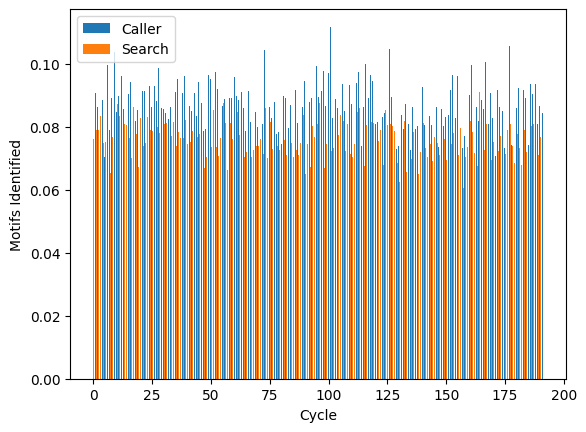

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration purposes
# Replace these with your actual data
cycles = np.arange(len(motifs_identified_caller_cycles))  # x positions for the bars
width = 0.35  # width of the bars

# Plotting
plt.bar(cycles - width/2, motifs_identified_caller_cycles, width, label='Caller')
plt.bar(cycles + width/2, motifs_identified_search_cycles, width, label='Search')

plt.xlabel('Cycle')
plt.ylabel('Motifs Identified')
plt.legend()
plt.show()



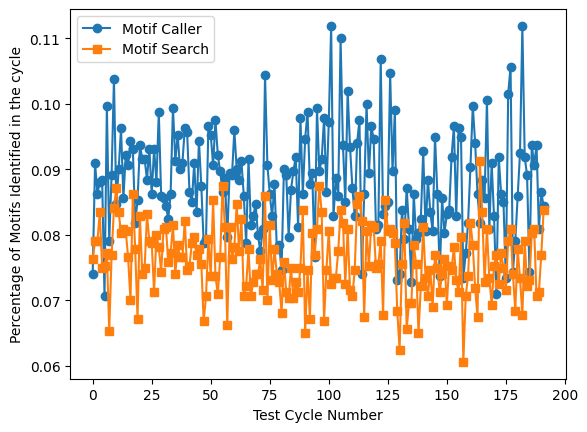

In [87]:
plt.plot(motifs_identified_caller_cycles, label='Motif Caller', marker='o')
plt.plot(motifs_identified_search_cycles, label='Motif Search', marker='s')
plt.xlabel('Test Cycle Number')
plt.ylabel('Percentage of Motifs Identified in the cycle')
plt.legend()
plt.show()


In [91]:
print(np.mean(motifs_identified_search_cycles))
print(np.mean(motifs_identified_caller_cycles))

0.07604003906250001
0.08819010416666666


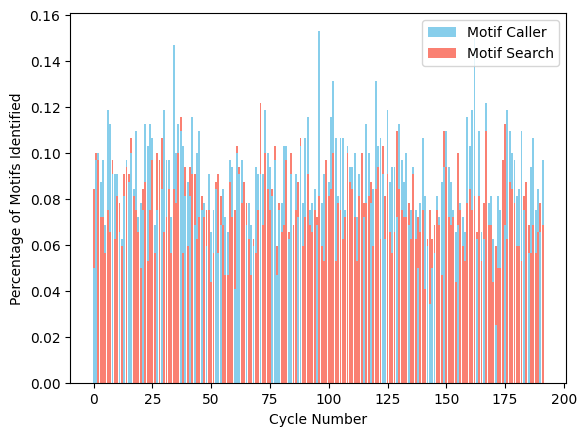

In [79]:
import matplotlib.pyplot as plt
import numpy as np

cycles = np.arange(len(motifs_identified_caller_cycles))  # x positions for the bars

# Initialize lists to store colors based on which is lower
lower_colors = []
higher_colors = []

# Determine lower and higher values for each cycle and assign colors
lower_values = []
higher_values = []

for caller, search in zip(motifs_identified_caller_cycles, motifs_identified_search_cycles):
    if caller < search:
        lower_values.append(caller)
        higher_values.append(search)
        lower_colors.append('skyblue')  # Color for "Caller" when it's the lower value
        higher_colors.append('salmon')  # Color for "Search" when it's the higher value
    else:
        lower_values.append(search)
        higher_values.append(caller)
        lower_colors.append('salmon')  # Color for "Search" when it's the lower value
        higher_colors.append('skyblue')  # Color for "Caller" when it's the higher value

# Create stacked bars
plt.bar(cycles, lower_values, color=lower_colors, label='Lower Value')
plt.bar(cycles, np.array(higher_values) - np.array(lower_values), bottom=lower_values, color=higher_colors, label='Higher Value')

# Labeling and legend
plt.xlabel('Cycle Number')
plt.ylabel('Percentage of Motifs Identified')
plt.legend(["Motif Caller", "Motif Search"])
plt.show()


In [63]:
print(np.mean(motifs_identified_caller_cycles))
print(np.mean(motifs_identified_search_cycles))

0.08785807291666665
0.07604166666666666


Inference takes about 5 min for 10,000 so like 2000 per minute
That's pretty slow ngl. Might be some way to make it quicker

In [4]:
dataset_df = pd.read_pickle(sampled_dataset_path)
payloads = dataset_df['Payload'].tolist()


def sort_transcript(transcript):

    cycles = [[] for i in range(8)]

    split_transcript = transcript.split()
    split_transcript = [int(i) for i in split_transcript  if i != '']

    for i in range(len(split_transcript)):
        
        found_motif = split_transcript[i]
        
        # If we have a payload motif
        if found_motif < 9:

            # finding the spacers - only for payload cycles
            if i > 0:

                # Checking for Back Spacer
                if split_transcript[i-1] > 10:
                    cycle_number = split_transcript[i-1] - 11
                    cycles[cycle_number].append(split_transcript[i])

                # Checking for Forward Spacer
                elif i < len(split_transcript) - 1:
                    if split_transcript[i+1] > 10:
                        cycle_number = split_transcript[i+1] - 11
                        cycles[cycle_number].append(split_transcript[i])

            else:
                if i < len(split_transcript) - 1:
                    # Checking for Forward Spacer
                    if split_transcript[i+1] > 10:
                        cycle_number = split_transcript[i+1] - 11
                        cycles[cycle_number].append(split_transcript[i])   

    return cycles


def get_payload_sequence(payload, actual_transcript, greedy_transcript):


    cycles_motif_read = sort_transcript(actual_transcript)
    cycles_motif_caller = sort_transcript(greedy_transcript)

    correct_motifs_predicted_motif_read = 0
    correct_motifs_predicted_motif_caller = 0

    incorrect_motifs_predicted_motif_read = 0
    incorrect_motifs_predicted_motif_caller = 0

    for i,j,k in zip(cycles_motif_read, cycles_motif_caller, payload):

        correct_motifs_predicted_motif_read += len(set(i).intersection(set(k)))
        correct_motifs_predicted_motif_caller += len(set(j).intersection(set(k)))
        incorrect_motifs_predicted_motif_read += len(set(i).difference(set(k)))
        incorrect_motifs_predicted_motif_caller += len(set(j).difference(set(k)))

    return correct_motifs_predicted_motif_read, correct_motifs_predicted_motif_caller, incorrect_motifs_predicted_motif_read, incorrect_motifs_predicted_motif_caller


correct_motifs_motif_read_arr = []
correct_motifs_motif_caller_arr = []
incorrect_motifs_predicted_motif_read_arr = []
incorrect_motifs_predicted_motif_caller_arr = []

for i in range(len(actual_transcripts)):
    correct_motifs_motif_read, correct_motifs_motif_caller, incorrect_motifs_predicted_motif_read, incorrect_motifs_predicted_motif_caller = get_payload_sequence(payloads[i], actual_transcripts[i], greedy_transcripts[i])

    correct_motifs_motif_read_arr.append(correct_motifs_motif_read)
    correct_motifs_motif_caller_arr.append(correct_motifs_motif_caller)
    incorrect_motifs_predicted_motif_read_arr.append(incorrect_motifs_predicted_motif_read)
    incorrect_motifs_predicted_motif_caller_arr.append(incorrect_motifs_predicted_motif_caller)



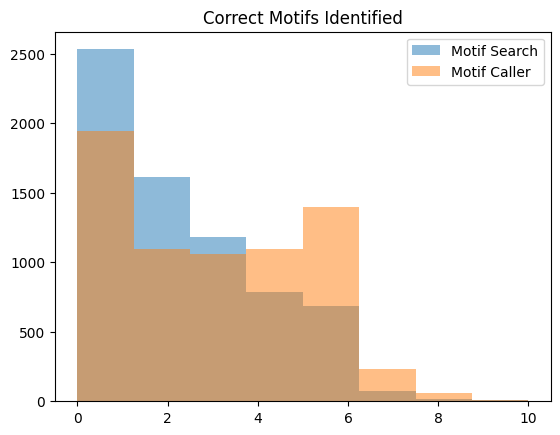

In [5]:
import matplotlib.pyplot as plt

plt.hist(correct_motifs_motif_read_arr, bins=8, alpha=0.5, label='Motif Search')
plt.hist(correct_motifs_motif_caller_arr, bins=8, alpha=0.5, label='Motif Caller')
plt.legend(loc='upper right')
plt.title("Correct Motifs Identified")
plt.show()

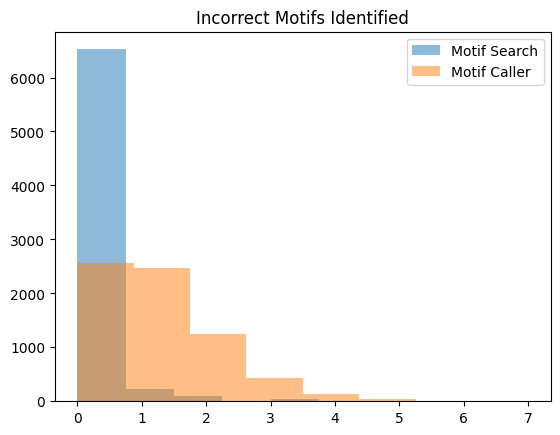

In [6]:
plt.hist(incorrect_motifs_predicted_motif_read_arr, bins=8, alpha=0.5, label='Motif Search')
plt.hist(incorrect_motifs_predicted_motif_caller_arr, bins=8, alpha=0.5, label='Motif Caller')
plt.legend(loc='upper right')
plt.title("Incorrect Motifs Identified")
plt.show()

In [50]:
dataset_df = dataset_df[:len(correct_motifs_motif_caller_arr)]

In [51]:
dataset_df['correct_motifs_motif_read'] = correct_motifs_motif_read_arr
dataset_df['correct_motifs_motif_caller'] = correct_motifs_motif_caller_arr
dataset_df['incorrect_motifs_predicted_motif_read'] = incorrect_motifs_predicted_motif_read_arr
dataset_df['incorrect_motifs_predicted_motif_caller'] = incorrect_motifs_predicted_motif_caller_arr

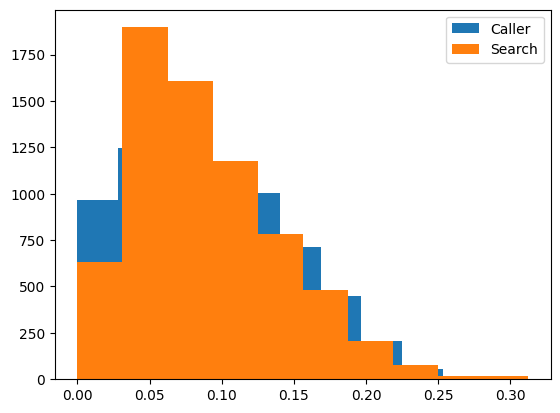

Caller Average motifs identified = 0.0865109152886568
Seach Average motifs identified = 0.07358300696257615


In [36]:
def get_motifs_identified_cycle_level(pred, target):

    motifs_identified = 0
    for pred_cycle, target_cycle in zip(pred, target):
        motifs_identifed_arr = [motif for motif in pred_cycle if motif in target_cycle]
        motifs_identified += len([motif for motif in pred_cycle if motif in target_cycle])

    return motifs_identified / 32

def get_motifs_identified_metrics():
    motifs_identifed_caller = []
    motifs_identifed_search = []
    for i, j, k in zip(greedy_transcripts, actual_transcripts, payloads):

        motifs_identifed_caller.append(get_motifs_identified_cycle_level(sort_transcript(i), k))
        motifs_identifed_search.append(get_motifs_identified_cycle_level(sort_transcript(j), k))

    plt.hist(motifs_identifed_caller, label='Caller')
    plt.hist(motifs_identifed_search, label='Search')
    plt.legend()
    plt.show()

    print(f"Caller Average motifs identified = {np.mean(motifs_identifed_caller)}")
    print(f"Seach Average motifs identified = {np.mean(motifs_identifed_search)}")

get_motifs_identified_metrics()

Caller Average motifs identified = 0.0960663257905425
Seach Average motifs identified = 0.07358300696257615


## Averaging over a single cycle

In [52]:


search_cycle_level_avg_error = []
search_cycle_level_avg_accuracy = []
search_cycle_level_least_error = []
search_cycle_level_best_accuracy = []

caller_cycle_level_avg_error = []
caller_cycle_level_avg_accuracy = []
caller_cycle_level_least_error = []
caller_cycle_level_best_accuracy = []

for i in dataset_df['ONT_Barcode'].unique():
    for j in dataset_df[dataset_df['ONT_Barcode'] == i]['HW_Address'].unique():

        subset_df = dataset_df[(dataset_df['ONT_Barcode'] == i) & (dataset_df['HW_Address'] == j)]
        
        search_avg_error = subset_df['incorrect_motifs_predicted_motif_read'].mean()
        search_avg_accuracy = subset_df['correct_motifs_motif_read'].mean()
        search_least_error = subset_df['incorrect_motifs_predicted_motif_read'].min()
        search_best_accuracy = subset_df['correct_motifs_motif_read'].max()
        
        caller_avg_error = subset_df['incorrect_motifs_predicted_motif_caller'].mean()
        caller_avg_accuracy = subset_df['correct_motifs_motif_caller'].mean()
        caller_least_error = subset_df['incorrect_motifs_predicted_motif_caller'].min()
        caller_best_accuracy = subset_df['correct_motifs_motif_caller'].max()
        
        

        search_cycle_level_avg_error.append(search_avg_error)
        search_cycle_level_avg_accuracy.append(search_avg_accuracy)
        search_cycle_level_least_error.append(search_least_error)
        search_cycle_level_best_accuracy.append(search_best_accuracy)
        
        caller_cycle_level_avg_error.append(caller_avg_error)
        caller_cycle_level_avg_accuracy.append(caller_avg_accuracy)
        caller_cycle_level_least_error.append(caller_least_error)
        caller_cycle_level_best_accuracy.append(caller_best_accuracy)


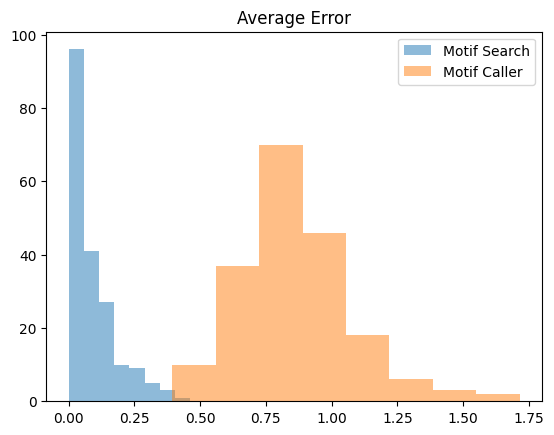

In [53]:
plt.hist(search_cycle_level_avg_error, bins=8, alpha=0.5, label='Motif Search')
plt.hist(caller_cycle_level_avg_error, bins=8, alpha=0.5, label='Motif Caller')
plt.legend(loc='upper right')
plt.title("Average Error")
plt.show()

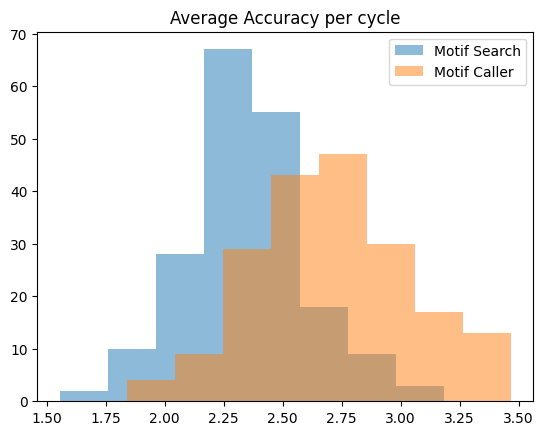

In [54]:
plt.hist(search_cycle_level_avg_accuracy, bins=8, alpha=0.5, label='Motif Search')
plt.hist(caller_cycle_level_avg_accuracy, bins=8, alpha=0.5, label='Motif Caller')
plt.legend(loc='upper right')
plt.title("Average Accuracy per cycle")
plt.show()

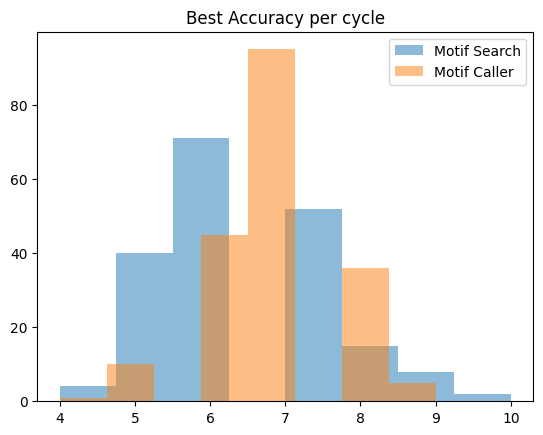

In [55]:
plt.hist(search_cycle_level_best_accuracy, bins=8, alpha=0.5, label='Motif Search')
plt.hist(caller_cycle_level_best_accuracy, bins=8, alpha=0.5, label='Motif Caller')
plt.legend(loc='upper right')
plt.title("Best Accuracy per cycle")
plt.show()

In [56]:


print(f"Average correct motifs identified per test cycle\n Motif Search: {np.mean(search_cycle_level_avg_accuracy):.4f}, Motif Caller: {np.mean(caller_cycle_level_avg_accuracy):.4f}")
print(f"Average incorrect motifs identified per test cycle\n Motif Search: {np.mean(search_cycle_level_avg_error):.4f}, Motif Caller: {np.mean(caller_cycle_level_avg_error):.4f}")
print(f"Best correct motifs identified per test cycle\n Motif Search: {np.mean(search_cycle_level_best_accuracy):.4f}, Motif Caller: {np.mean(caller_cycle_level_best_accuracy):.4f}")


Average correct motifs identified per test cycle
 Motif Search: 2.3472, Motif Caller: 2.7056
Average incorrect motifs identified per test cycle
 Motif Search: 0.0862, Motif Caller: 0.8594
Best correct motifs identified per test cycle
 Motif Search: 6.3438, Motif Caller: 6.8854


Average Performance Improvement of 24 % 
Best Performance Improvement of 

## Motif Tallies and Recovery
Want to explore how many reads before we get all the motifs naturally

In [57]:
dataset_df['greedy_transcript'] = greedy_transcripts[:len(actual_transcripts)]
dataset_df['actual_transcript'] = actual_transcripts[:len(greedy_transcripts)]

In [58]:

def get_motif_tallies_cycle(cycle):

    motif_tallies = [[0 for i in range(8)] for i in range(8)]

    for i in range(len(cycle)):
        for j in range(len(cycle[i])):
            motif_tallies[i][cycle[i][j]-1] += 1

    return motif_tallies

def extract_motif_tallies_cycle(ONT_Barcode, HW_Address):

    subset_df = dataset_df[(dataset_df['ONT_Barcode'] == ONT_Barcode) & (dataset_df['HW_Address'] == HW_Address)]

    payloads = subset_df['Payload'].tolist()
    actual_transcripts = subset_df['actual_transcript'].tolist()
    greedy_transcripts = subset_df['greedy_transcript'].tolist()

    motif_search_tallies_arr = []
    motif_caller_tallies_arr = []

    for payload, actual, greedy in zip(payloads, actual_transcripts, greedy_transcripts):

        motif_read_cycle = sort_transcript(actual)
        motif_caller_cycle = sort_transcript(greedy)

        motif_read_tallies = get_motif_tallies_cycle(motif_read_cycle)
        motif_caller_tallies = get_motif_tallies_cycle(motif_caller_cycle)

        motif_search_tallies_arr.append(motif_read_tallies)
        motif_caller_tallies_arr.append(motif_caller_tallies)

    return motif_search_tallies_arr, motif_caller_tallies_arr



payload_tallies = []
motif_search_tallies_dict = {}
motif_caller_tallies_dict = {}

for i in dataset_df['ONT_Barcode'].unique():

    for j in dataset_df[dataset_df['ONT_Barcode'] == i]['HW_Address'].unique():
        payload = dataset_df[(dataset_df['ONT_Barcode'] == i) & (dataset_df['HW_Address'] == j)]['Payload'].tolist()[0]
        payload_tallies = get_motif_tallies_cycle(payload)
        motif_search_tallies, motif_caller_tallies = extract_motif_tallies_cycle(i, j)
    
        motif_search_tallies_dict[f'{i}_{j}'] = motif_search_tallies
        motif_caller_tallies_dict[f'{i}_{j}'] = motif_caller_tallies

In [59]:
import operator
import heapq

def get_top_4_motifs_per_payload(tallies_arr, n_reads=None):

    if n_reads:
        tallies_arr = tallies_arr[:n_reads]

    # Need to get index of top four in tallies per position

    # Sum up tallies 
    tallies_arr = np.array(tallies_arr)

    # Sum across each position
    tallies_arr = np.sum(tallies_arr, axis=0)

    top_4_motifs = []

    for tally in tallies_arr:

        tallies_dict = {i:tally[i] for i in range(8)}
        # Sort by value and get top 4 keys
        top_4_local = heapq.nlargest(4, tallies_dict, key=tallies_dict.get)
        
        top_4_local = [k+1 for k in top_4_local if tally[k] > 0]
                
        top_4_motifs.append(top_4_local)

    return top_4_motifs

In [60]:

def get_percentage_cycle_recovered(prediction_cycle, payload):

    total_motifs = 32

    return sum([len(set(i).intersection(set(j))) for i,j in zip(prediction_cycle, payload)])/total_motifs


search_percentage_cycle_recovered = []
caller_percentage_cycle_recovered = []

for i in dataset_df['ONT_Barcode'].unique():
    for j in dataset_df[dataset_df['ONT_Barcode'] == i]['HW_Address'].unique():
        
        payload = dataset_df[(dataset_df['ONT_Barcode'] == i) & (dataset_df['HW_Address'] == j)]['Payload'].tolist()[0]
        search_tallies = motif_search_tallies_dict[f'{i}_{j}']
        caller_tallies = motif_caller_tallies_dict[f'{i}_{j}']

        search_top_4 = get_top_4_motifs_per_payload(search_tallies, n_reads=2)
        caller_top_4 = get_top_4_motifs_per_payload(caller_tallies, n_reads=2)

        search_cycle_rec = get_percentage_cycle_recovered(search_top_4, payload)
        caller_cycle_rec = get_percentage_cycle_recovered(caller_top_4, payload)

        search_percentage_cycle_recovered.append(search_cycle_rec)
        caller_percentage_cycle_recovered.append(caller_cycle_rec)

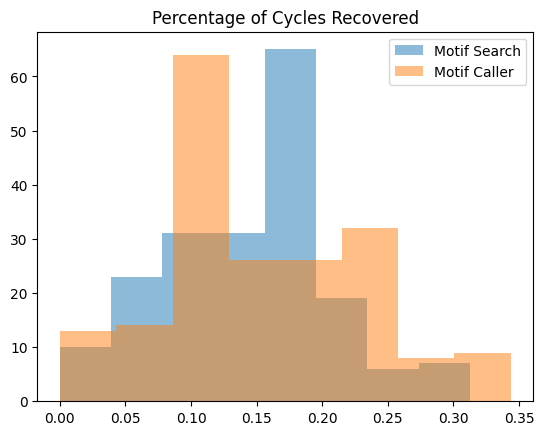

0.14192708333333334 0.15559895833333334


In [61]:
plt.hist(search_percentage_cycle_recovered, bins=8, alpha=0.5, label='Motif Search')
plt.hist(caller_percentage_cycle_recovered, bins=8, alpha=0.5, label='Motif Caller')
plt.legend(loc='upper right')
plt.title("Percentage of Cycles Recovered")
plt.show()
print(np.mean(search_percentage_cycle_recovered), np.mean(caller_percentage_cycle_recovered))

In [98]:
np.mean(search_percentage_cycle_recovered), np.mean(caller_percentage_cycle_recovered)

(np.float64(0.9867021276595744), np.float64(0.8863031914893617))

Processing 11.11%
Processing 22.22%
Processing 33.33%
Processing 44.44%
Processing 55.56%
Processing 66.67%
Processing 77.78%
Processing 88.89%
Processing 100.00%


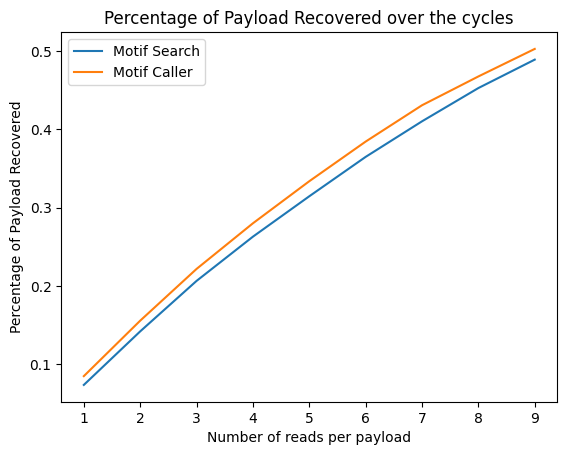

In [65]:

def get_cycles_recovered_per_reads(n_reads):
    
    search_percentage_cycle_recovered = []
    caller_percentage_cycle_recovered = []

    for i in dataset_df['ONT_Barcode'].unique():
        for j in dataset_df[dataset_df['ONT_Barcode'] == i]['HW_Address'].unique():
            
            payload = dataset_df[(dataset_df['ONT_Barcode'] == i) & (dataset_df['HW_Address'] == j)]['Payload'].tolist()[0]
            search_tallies = motif_search_tallies_dict[f'{i}_{j}']
            caller_tallies = motif_caller_tallies_dict[f'{i}_{j}']

            

            search_top_4 = get_top_4_motifs_per_payload(search_tallies, n_reads=n_reads)
            caller_top_4 = get_top_4_motifs_per_payload(caller_tallies, n_reads=n_reads)


            search_cycle_rec = get_percentage_cycle_recovered(search_top_4, payload)
            caller_cycle_rec = get_percentage_cycle_recovered(caller_top_4, payload)

            search_percentage_cycle_recovered.append(search_cycle_rec)
            caller_percentage_cycle_recovered.append(caller_cycle_rec)

    return np.mean(search_percentage_cycle_recovered), np.mean(caller_percentage_cycle_recovered)


search_cycle_recovered_arr = []
caller_cycle_recovered_arr = []


n_reads = np.arange(1, 10, 1)
repeats = 10

for i in n_reads:
    print(f"Processing {i/len(n_reads)*100:.2f}%")

    search_cycle_locals = []
    caller_cycle_locals = []
    for j in range(repeats):
        search_cycle_recovered, caller_cycle_recovered = get_cycles_recovered_per_reads(i)
        search_cycle_locals.append(search_cycle_recovered)
        caller_cycle_locals.append(caller_cycle_recovered)

    search_cycle_recovered_arr.append(np.mean(search_cycle_locals))
    caller_cycle_recovered_arr.append(np.mean(caller_cycle_locals))

plt.plot(n_reads, search_cycle_recovered_arr, label='Motif Search')
plt.plot(n_reads, caller_cycle_recovered_arr, label='Motif Caller')
plt.xlabel("Number of reads per payload")
plt.ylabel("Percentage of Payload Recovered")
plt.legend(loc='upper left')
plt.title("Percentage of Payload Recovered over the cycles")
plt.show()

## Saturate at the same amount - motif caller gets there way before. That is better demonstrably. Need to see on the whole dataset

In [42]:
def create_spacer_sequence(cycles):

    spacer_sequence = []

    cycle_number = 11

    """
    if cycles.isinstance(str):
        payload = eval(cycles)
    """
        
    for i in cycles:
        for j in i:
            spacer_sequence.append(cycle_number)
            spacer_sequence.append(j)
            spacer_sequence.append(cycle_number)
        cycle_number += 1

    return spacer_sequence

In [46]:
for i in range(len(greedy_transcripts[10:15])):

    print(greedy_transcripts[i])
    print(actual_transcripts[i])
    print(str(create_spacer_sequence(payloads[i])))
    print()

1 11 4 12 13 1 13 14 14 14 16
 10 1 10 11 8 11 12 4 12 13 1 13 14 8 14 15 8 15 17 4 17
[11, 3, 11, 11, 6, 11, 11, 7, 11, 11, 8, 11, 12, 3, 12, 12, 4, 12, 12, 5, 12, 12, 8, 12, 13, 1, 13, 13, 2, 13, 13, 4, 13, 13, 6, 13, 14, 1, 14, 14, 2, 14, 14, 5, 14, 14, 6, 14, 15, 4, 15, 15, 5, 15, 15, 6, 15, 15, 8, 15, 16, 1, 16, 16, 2, 16, 16, 5, 16, 16, 7, 16, 17, 1, 17, 17, 3, 17, 17, 4, 17, 17, 7, 17, 18, 2, 18, 18, 4, 18, 18, 5, 18, 18, 7, 18]

1 10 1 11 11 12 4 13 13 14 1 14 15 6 15 1 17 3 18
 9 1 9 11 6 11 13 4 13 14 1 14
[11, 3, 11, 11, 6, 11, 11, 7, 11, 11, 8, 11, 12, 3, 12, 12, 4, 12, 12, 5, 12, 12, 8, 12, 13, 1, 13, 13, 2, 13, 13, 4, 13, 13, 6, 13, 14, 1, 14, 14, 2, 14, 14, 5, 14, 14, 6, 14, 15, 4, 15, 15, 5, 15, 15, 6, 15, 15, 8, 15, 16, 1, 16, 16, 2, 16, 16, 5, 16, 16, 7, 16, 17, 1, 17, 17, 3, 17, 17, 4, 17, 17, 7, 17, 18, 2, 18, 18, 4, 18, 18, 5, 18, 18, 7, 18]

1 1 11 12 8 12 13 14 14 15 4 15 16 4 17
 12 8 12 13 4 13
[11, 3, 11, 11, 6, 11, 11, 7, 11, 11, 8, 11, 12, 3, 12, 12, 4, 12, 

## Error by Motif Choice

In [6]:
def get_motif_counts(read_motifs):
    motif_counts = np.zeros(13, dtype=int)
    for motif in read_motifs:
        motif_counts[motif-1] += 1
    return motif_counts

motifs_missed = np.zeros(13, dtype=int)
total_motifs = np.zeros(13, dtype=int)

for i, j in zip(greedy_transcripts, actual_transcripts):

    i = eval('['+i.replace(' ',',') +']')

    j = j.strip()
    j = eval('['+j.replace(' ',',') +']')

    motif_counts_per_read = get_motif_counts(i)
    dataset_motif_counts = get_motif_counts(j)

    motifs_missed = [
            i + (k - j) if k>j else i for i, j, k in zip(
                motifs_missed, motif_counts_per_read, 
                dataset_motif_counts
            )
        ]
    total_motifs = [i + j for i, j in zip(total_motifs, dataset_motif_counts)]


In [20]:
percentage_motifs_missed = [i/j for i,j in zip(motifs_missed, total_motifs)]

In [21]:
percentage_motifs_missed

[0.10629744035515266,
 0.2490049751243781,
 0.17147117296222664,
 0.24420788979336255,
 0.23159700561447286,
 0.3884959924563885,
 0.1804418353159277,
 0.36564756491012446,
 0.30166196299780496,
 0.30865172087148723,
 0.23724095267553355,
 0.3018955873213176,
 0.33064883756268043]

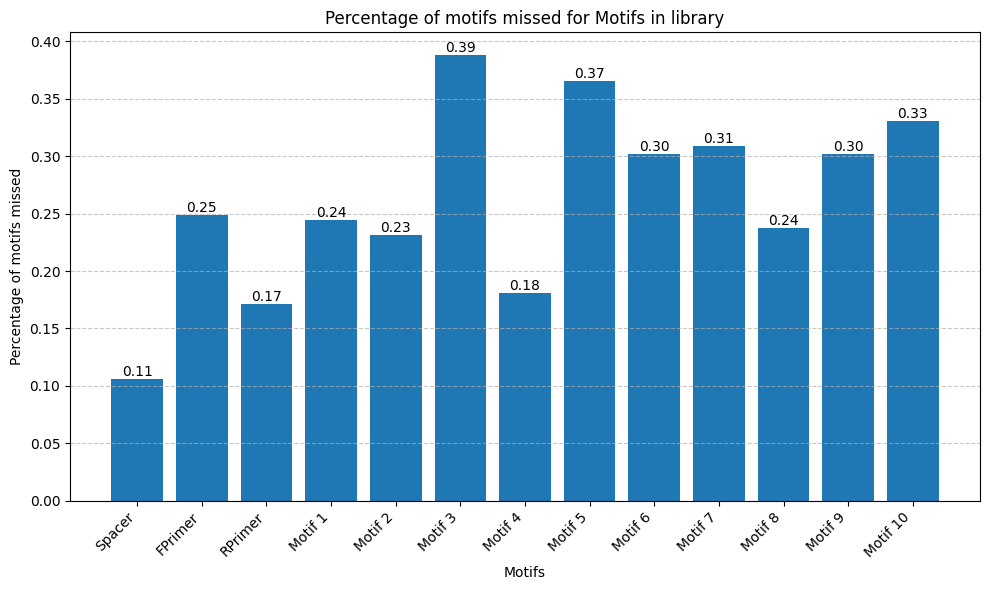

In [22]:
motif_labels = ["Spacer", "FPrimer", "RPrimer"] + [f"Motif {i+1}" for i in range(10)]
missed_counts = motifs_missed
motifs = motif_labels

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(motifs, percentage_motifs_missed)

# Customize the chart
plt.title('Percentage of motifs missed for Motifs in library')
plt.xlabel('Motifs')
plt.ylabel('Percentage of motifs missed')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels if they overlap
plt.xticks(rotation=45, ha='right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Alignment Metric

In [74]:
# So for each read - get the information motifs from the target  
# Similary for the prediction
# See what difference is there -> direct correct prediction or next matches or whatever

counter = 0
for i, j in zip(greedy_transcripts, actual_transcripts):

    i = eval('['+i.replace(' ',',') +']')

    j = j.strip()
    j = eval('['+j.replace(' ',',') +']')

    print([t for t in i if not (t == 1 or t==2 or t==3)])
    print([t for t in j if not (t == 1 or t==2 or t==3)])
    print()

    if counter == 5:
        break
    counter +=1


[4, 9, 4, 11, 11, 9, 12, 9, 5, 13]
[6, 9, 8, 5, 11, 5, 13, 6, 13, 7, 5]

[4, 11, 9, 13, 6, 4, 5, 10, 9, 11, 5, 11, 12, 8, 13, 11, 5, 13, 13]
[4, 11, 9, 13, 6, 4, 5, 10, 9, 11, 5, 11, 12, 8, 13, 11, 5, 13, 13, 8]

[11, 8, 5, 12, 7, 5, 13, 11, 4, 5, 7, 9, 9, 13, 13, 9]
[11, 8, 5, 12, 11, 13, 7, 5, 13, 11, 4, 5, 7, 9, 9, 13, 13, 9]

[7, 5, 7, 4, 13, 12]
[5, 7, 4, 13, 12]

[13, 9, 10, 13, 10, 7, 12, 7, 7, 4]
[6, 13, 5, 5, 11, 13, 13, 8, 11, 8, 6, 10, 11, 13, 4]

[5, 7, 7, 9, 13, 5, 7, 13, 4, 7]
[5, 7, 4, 13, 6, 12, 13, 5, 7, 10, 13, 7]



In [75]:
def alignment_errors(seq1, seq2):
    m, n = len(seq1), len(seq2)
    dp = [[[0, ''] for _ in range(n + 1)] for _ in range(m + 1)]
    
    for i in range(m + 1):
        dp[i][0] = [i, 'D' * i]
    for j in range(n + 1):
        dp[0][j] = [j, 'I' * j]
    
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if seq1[i-1] == seq2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                deletion = dp[i-1][j][0] + 1
                insertion = dp[i][j-1][0] + 1
                substitution = dp[i-1][j-1][0] + 1
                
                min_op = min(deletion, insertion, substitution)
                dp[i][j][0] = min_op
                
                if min_op == deletion:
                    dp[i][j][1] = dp[i-1][j][1] + 'D'
                elif min_op == insertion:
                    dp[i][j][1] = dp[i][j-1][1] + 'I'
                else:
                    dp[i][j][1] = dp[i-1][j-1][1] + 'S'
    
    operations = dp[m][n][1]
    max_length = max(m, n)
    
    insertions = operations.count('I') / max_length
    deletions = operations.count('D') / max_length
    substitutions = operations.count('S') / max_length
    
    return insertions, deletions, substitutions

# Example sequences
sequence_pairs = [
    ([4, 9, 4, 11, 11, 9, 12, 9, 5, 13], [6, 9, 8, 5, 11, 5, 13, 6, 13, 7, 5]),
    ([4, 11, 9, 13, 6, 4, 5, 10, 9, 11, 5, 11, 12, 8, 13, 11, 5, 13, 13], 
     [4, 11, 9, 13, 6, 4, 5, 10, 9, 11, 5, 11, 12, 8, 13, 11, 5, 13, 13, 8]),
    ([11, 8, 5, 12, 7, 5, 13, 11, 4, 5, 7, 9, 9, 13, 13, 9], 
     [11, 8, 5, 12, 11, 13, 7, 5, 13, 11, 4, 5, 7, 9, 9, 13, 13, 9]),
    ([7, 5, 7, 4, 13, 12], [5, 7, 4, 13, 12]),
    ([13, 9, 10, 13, 10, 7, 12, 7, 7, 4], 
     [6, 13, 5, 5, 11, 13, 13, 8, 11, 8, 6, 10, 11, 13, 4]),
    ([5, 7, 7, 9, 13, 5, 7, 13, 4, 7], [5, 7, 4, 13, 6, 12, 13, 5, 7, 10, 13, 7])
]

# Calculate and print alignment errors
for i, (seq1, seq2) in enumerate(sequence_pairs, 1):
    ins, dele, sub = alignment_errors(seq1, seq2)
    print(f"Pair {i}:")
    print(f"  Insertion error rate: {ins:.4f}")
    print(f"  Deletion error rate: {dele:.4f}")
    print(f"  Substitution error rate: {sub:.4f}")
    print(f"  Total error rate: {ins + dele + sub:.4f}")
    print()

Pair 1:
  Insertion error rate: 0.1818
  Deletion error rate: 0.0909
  Substitution error rate: 0.5455
  Total error rate: 0.8182

Pair 2:
  Insertion error rate: 0.0500
  Deletion error rate: 0.0000
  Substitution error rate: 0.0000
  Total error rate: 0.0500

Pair 3:
  Insertion error rate: 0.1111
  Deletion error rate: 0.0000
  Substitution error rate: 0.0000
  Total error rate: 0.1111

Pair 4:
  Insertion error rate: 0.0000
  Deletion error rate: 0.1667
  Substitution error rate: 0.0000
  Total error rate: 0.1667

Pair 5:
  Insertion error rate: 0.3333
  Deletion error rate: 0.0000
  Substitution error rate: 0.4667
  Total error rate: 0.8000

Pair 6:
  Insertion error rate: 0.2500
  Deletion error rate: 0.0833
  Substitution error rate: 0.1667
  Total error rate: 0.5000



In [77]:
def calculate_error_rates(ground_truth, prediction):
    insertions = 0
    deletions = 0
    substitutions = 0
    
    i, j = 0, 0
    while i < len(ground_truth) and j < len(prediction):
        if ground_truth[i] == prediction[j]:
            i += 1
            j += 1
        elif j + 1 < len(prediction) and ground_truth[i] == prediction[j + 1]:
            # Insertion
            insertions += 1
            j += 1
        elif i + 1 < len(ground_truth) and ground_truth[i + 1] == prediction[j]:
            # Deletion
            deletions += 1
            i += 1
        else:
            # Substitution
            substitutions += 1
            i += 1
            j += 1
    
    # Count remaining insertions or deletions
    insertions += len(prediction) - j
    deletions += len(ground_truth) - i
    
    total_length = len(ground_truth)
    
    return {
        "insertion_rate": insertions / total_length,
        "deletion_rate": deletions / total_length,
        "substitution_rate": substitutions / total_length,
        "total_error_rate": (insertions + deletions + substitutions) / total_length
    }


In [81]:
counter = 0
insertion_rates = []
subsitution_rates = []
deletion_rates = []
total_alignment_error_rates = []
for i, j in zip(greedy_transcripts, actual_transcripts):

    i = eval('['+i.replace(' ',',') +']')

    j = j.strip()
    j = eval('['+j.replace(' ',',') +']')

    prediction_motifs = [t for t in i if not (t == 1 or t==2 or t==3)]
    target_motifs = [t for t in j if not (t == 1 or t==2 or t==3)]
    
    error_rates = calculate_error_rates(target_motifs, prediction_motifs)

    insertion_rates.append(error_rates['insertion_rate'])
    subsitution_rates.append(error_rates['substitution_rate'])
    deletion_rates.append(error_rates['deletion_rate'])
    total_alignment_error_rates.append(error_rates['total_error_rate'])
 

In [83]:
np.mean(insertion_rates)

0.04243048583541574

In [84]:
np.mean(deletion_rates)

0.17529048888465143

In [85]:
np.mean(subsitution_rates)

0.2660318444270431

<BarContainer object of 3 artists>

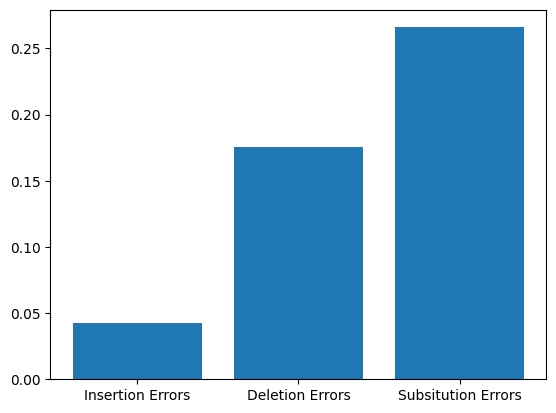

In [91]:
columns = ['Insertion Errors', 'Deletion Errors', 'Subsitution Errors']
rates = [np.mean(insertion_rates), np.mean(deletion_rates), np.mean(subsitution_rates)]

plt.bar(columns, rates)

## Training curve

In [67]:
log_path = r"C:\Users\Parv\OneDrive\Documents\models\log.txt"
log_text = ""

In [23]:
with open(log_path, "r") as f:
    log_text = f.readlines()

In [43]:

epochs = []
batch = []
loss = []
motifs_identified = []
edit_distance = []
for i in log_text:
    if i == '\n':
        continue
    split_line = i.split()
    if len(split_line) > 5:
        epochs.append(split_line[1])
        batch.append(split_line[3])
        loss.append(split_line[5])
        motifs_identified.append(split_line[-1])
        edit_distance.append(split_line[-3])

In [53]:
edit_distance = [float(i.replace('Motifs', '')) for i in edit_distance if not (i=='Edit' or i =='')]